In [1]:
import logging
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from custom_losses import *
from custom_metrics import *
from preprocessing import *
from models import create_w_net, create_unet
import os
import cv2
from PIL import Image


In [2]:
logging.getLogger().setLevel(logging.WARNING)

In [3]:
# Define paths to your dataset
image_folder = 'DRIVE/training/images'
label_folder = 'DRIVE/training/manual'
mask_folder = 'DRIVE/training/mask'
test_image_folder = 'DRIVE/test/images'
test_label_folder = 'DRIVE/test/manual'
test_mask_folder = 'DRIVE/training/mask'
# Get list of all files in the image and label directories
image_files = sorted(os.listdir(image_folder))
label_files = sorted(os.listdir(label_folder))
mask_files = sorted(os.listdir(mask_folder))
test_image_files = sorted(os.listdir(test_image_folder))
test_label_files = sorted(os.listdir(test_label_folder))
test_mask_files = sorted(os.listdir(test_mask_folder))

In [6]:
create_w_net((512,512,3), 2, 8).summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_6 (Functional)           (None, 512, 512, 1)  30105       ['input_5[0][0]']                
                                                                                                  
 concatenate_14 (Concatenate)   (None, 512, 512, 4)  0           ['input_5[0][0]',                
                                                                  'model_6[0][0]']                
                                                                                            

In [ ]:
# Function to preprocess images and labels
def preprocess(image_path, label_path, mask_path):
    # Convert the TensorFlow Tensor object to a string
    image_path = image_path.decode('utf-8')
    label_path = label_path.decode('utf-8')
    mask_path = mask_path.decode('utf-8')
    # Load image and label
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    try:
        label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if label is None or mask is None:
            raise FileNotFoundError
    except FileNotFoundError:
        lb = Image.open(label_path)
        lb.seek(lb.tell())
        label = np.array(lb)
        mask = Image.open(mask_path)
        mask.seek(mask.tell())
        mask = np.array(mask).astype(np.uint8)
    # Resize images and labels
    input = ResizePreprocessor(512, 512)
    x = CLAHE()(input)
    x = MedianBlurPreprocessor()(x)
    x = GammaCorrectionPreprocessor()(x)
    x = MultiScaleMorphologicalPreprocessor(
        operation='open',  # Options: 'dilate', 'erode', 'open', 'close'
        kernel_sizes=[3, 5, 7],
        kernel_shape=cv2.MORPH_RECT,
        iterations=1
    )(x)
    NormalizePreprocessor()(x)
    for_labels = ResizePreprocessor(512, 512)
    NormalizePreprocessor()(for_labels)
    image = input.process(image)[:, :, np.newaxis].astype('float32')
    label = for_labels.process(label)[:, :, np.newaxis].astype('float32')
    mask = for_labels.process(mask)[:, :, np.newaxis].astype('float32')
    image *= mask
    label *= mask
    return image, label



In [69]:
# Function to load the dataset into tf.data.Dataset
def load_dataset(image_folder,image_files, label_folder, label_files, mask_folder, mask_files):
    # Create file paths
    image_paths = [os.path.join(image_folder, f) for f in image_files]
    label_paths = [os.path.join(label_folder, f) for f in label_files]
    mask_paths = [os.path.join(mask_folder, f) for f in mask_files]
    # Create a TensorFlow dataset from the file paths
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_paths, mask_paths))
    
    # Map the preprocessing function to each element in the dataset
    dataset = dataset.map(lambda img_path, lbl_path, m_path: tf.numpy_function(
                          func=preprocess, inp=[img_path, lbl_path, m_path], 
                          Tout=[tf.float32, tf.float32]))
    
    # Shuffle and batch the dataset
    dataset = dataset.shuffle(buffer_size=len(image_paths))
    dataset = dataset.batch(4)  # Set batch size to 32, modify as needed
    
    return dataset



In [70]:
# Load the dataset
dataset = load_dataset(image_folder, image_files, label_folder, label_files, mask_folder, mask_files)
test_dataset= load_dataset(test_image_folder, test_image_files, test_label_folder, test_label_files, test_mask_folder, test_mask_files)

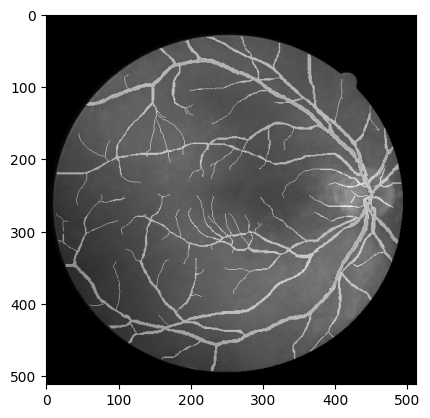

In [62]:
for image, label in test_dataset:
    
    plt.imshow(image[0]*.6 + label[0]*.4, cmap='gray')

In [71]:
class LogHistoryToExcel(tf.keras.callbacks.Callback):
    def __init__(self, file_name='training_log.xlsx'):
        super(LogHistoryToExcel, self).__init__()
        self.file_name = file_name
        self.epoch_data = []

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['epoch'] = epoch + 1
        self.epoch_data.append(logs)

        # Convert epoch data to DataFrame and write to Excel
        df = pd.DataFrame(self.epoch_data)
        df.to_excel(self.file_name, index=False)

In [72]:
# Define the total number of epochs
total_epochs = 1000

# Set the initial learning rate, decay steps, and minimum learning rate
initial_learning_rate = 1E-2
decay_steps = 50
alpha = 1E-8
class LearningRateLogger(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Get the learning rate from the optimizer
        lr = self.model.optimizer.learning_rate
        if isinstance(lr, tf.keras.optimizers.schedules.LearningRateSchedule):
            current_lr = lr(tf.cast(self.model.optimizer.iterations, tf.float32))
        else:
            current_lr = lr
        print(f"Epoch {epoch + 1}: Learning rate is {current_lr.numpy()}")

# Create a cosine decay schedule with restarts and a minimum learning rate
lr_schedule = tf.keras.optimizers.schedules.CosineDecayRestarts(
    initial_learning_rate=initial_learning_rate,
    first_decay_steps=decay_steps,
    alpha=alpha
)

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_80 (Conv2D)             (None, 512, 512, 8)  80          ['input_5[0][0]']                
                                                                                                  
 batch_normalization_80 (BatchN  (None, 512, 512, 8)  32         ['conv2d_80[0][0]']              
 ormalization)                                                                                    
                                                                                            

In [74]:

wnet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1E-3), loss={"out1":DiceLoss(), "out2":DiceLoss()}, metrics=[iou_metric])


In [75]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=50, verbose=1, mode='min')
wnet.fit(x=dataset, epochs=2000, verbose=2, callbacks=[early_stopping, LearningRateLogger(), LogHistoryToExcel(
    "models_data/model_with_gray_image_conv_plus_preproc.xlsx")], validation_data=test_dataset)

Epoch 1/2000
Epoch 1: Learning rate is 0.0010000000474974513
5/5 - 8s - loss: 1.4505 - out1_loss: 0.7024 - out2_loss: 0.7481 - out1_iou_metric: 0.1031 - out2_iou_metric: 0.0910 - val_loss: 1.4887 - val_out1_loss: 0.7451 - val_out2_loss: 0.7436 - val_out1_iou_metric: 0.0778 - val_out2_iou_metric: 0.0781 - epoch: 1.0000 - 8s/epoch - 2s/step
Epoch 2/2000
Epoch 2: Learning rate is 0.0010000000474974513
5/5 - 3s - loss: 1.3044 - out1_loss: 0.6593 - out2_loss: 0.6451 - out1_iou_metric: 0.1186 - out2_iou_metric: 0.1324 - val_loss: 1.4833 - val_out1_loss: 0.7424 - val_out2_loss: 0.7408 - val_out1_iou_metric: 0.0774 - val_out2_iou_metric: 0.0777 - epoch: 2.0000 - 3s/epoch - 579ms/step
Epoch 3/2000
Epoch 3: Learning rate is 0.0010000000474974513
5/5 - 3s - loss: 1.1943 - out1_loss: 0.6244 - out2_loss: 0.5699 - out1_iou_metric: 0.1307 - out2_iou_metric: 0.1596 - val_loss: 1.4761 - val_out1_loss: 0.7392 - val_out2_loss: 0.7369 - val_out1_iou_metric: 0.0769 - val_out2_iou_metric: 0.0771 - epoch: 3.

KeyboardInterrupt: 

1/1 [==============================] - 0s 44ms/step


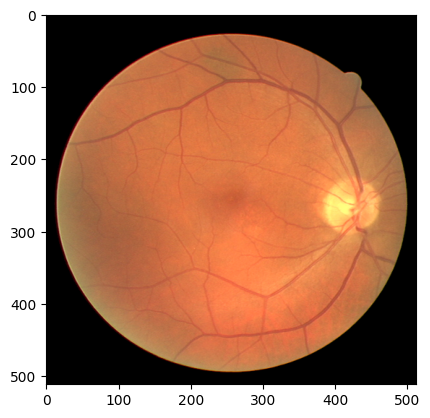

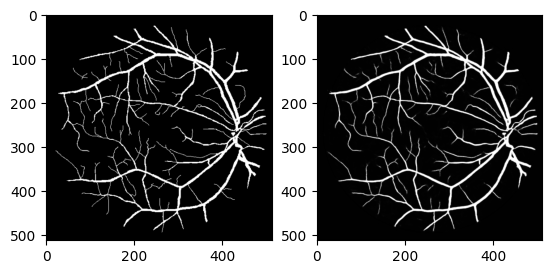

1/1 [==============================] - 0s 31ms/step


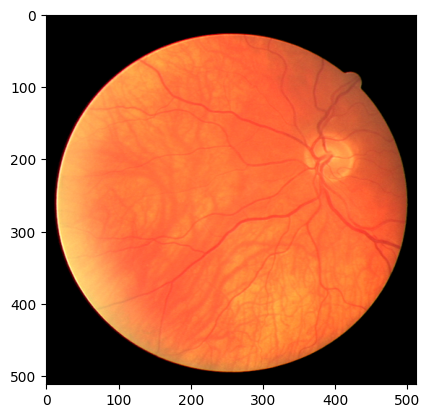

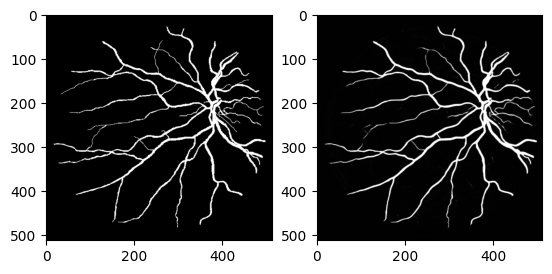

1/1 [==============================] - 0s 28ms/step


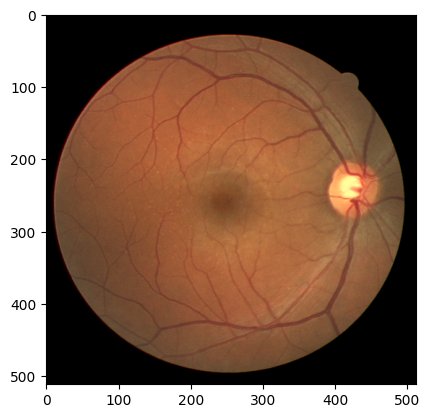

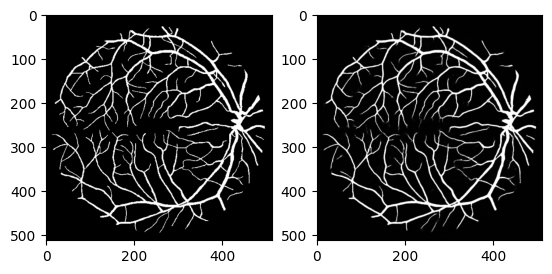

1/1 [==============================] - 0s 30ms/step


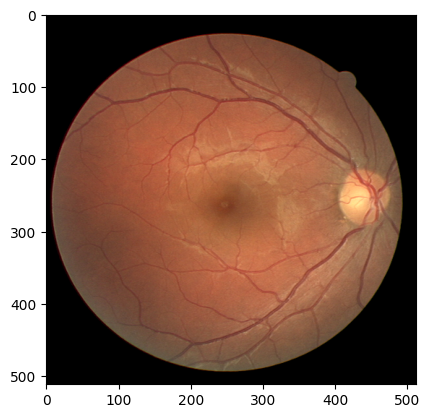

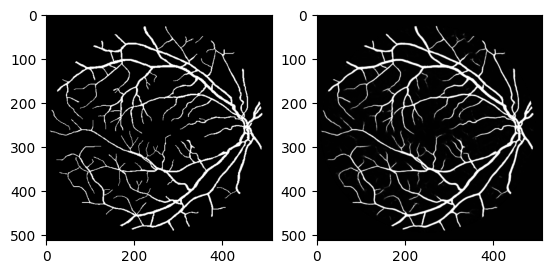

1/1 [==============================] - 0s 33ms/step


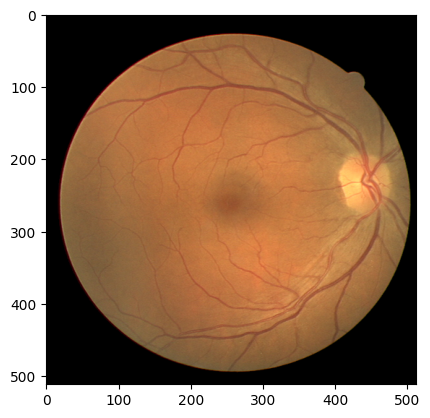

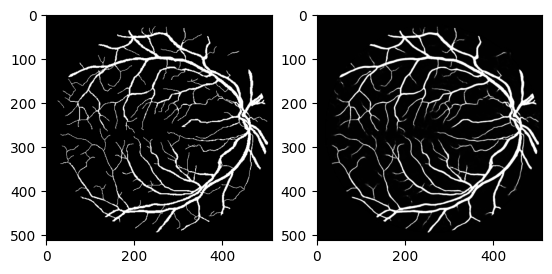

In [56]:
for batch in dataset:
    image, label = batch
    pl = wnet.predict(image)[1]
    plt.imshow(image[0])
    plt.show()
    fig, axs = plt.subplots(1,2)
    axs[0].imshow(label[0], cmap="gray")
    axs[1].imshow(pl[0], cmap="gray")
    plt.show()
    

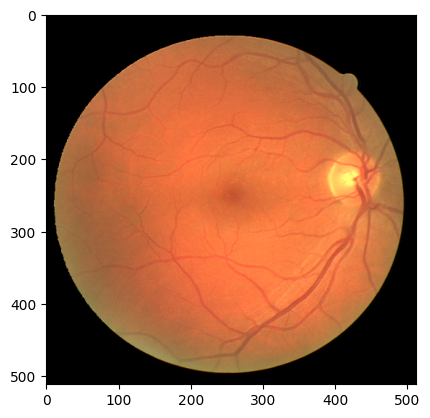

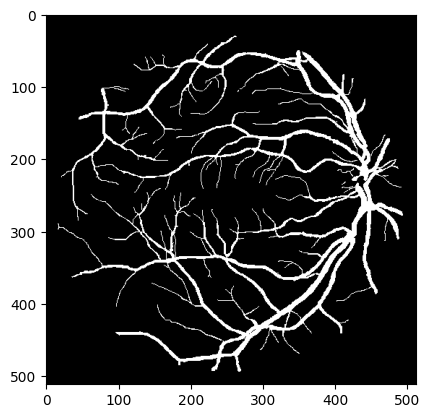

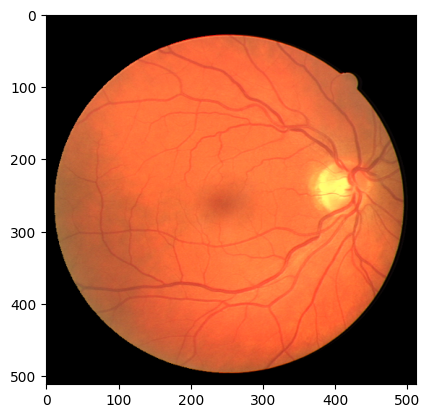

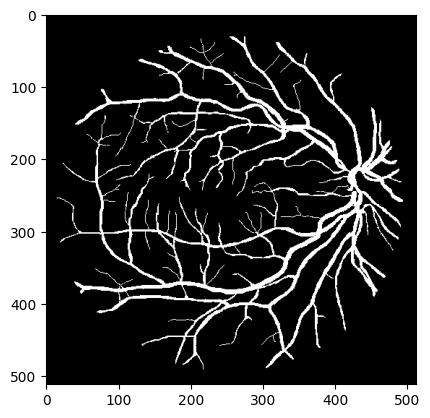

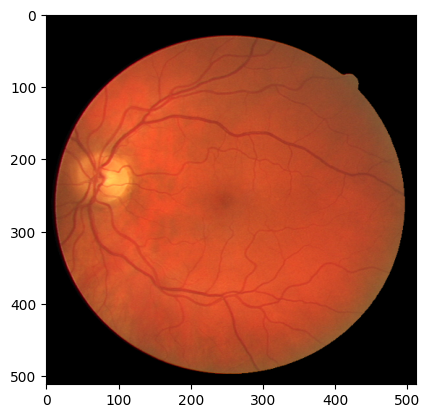

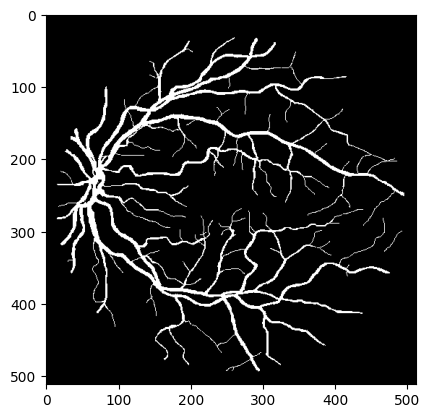

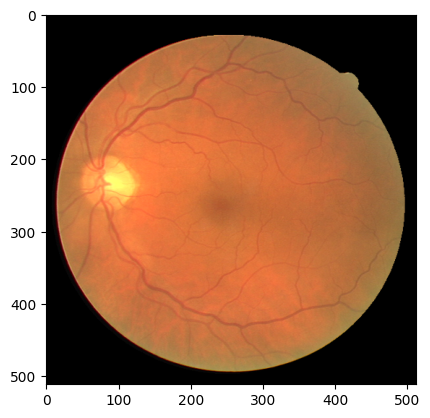

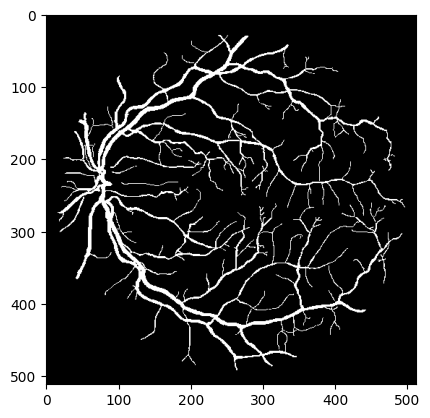

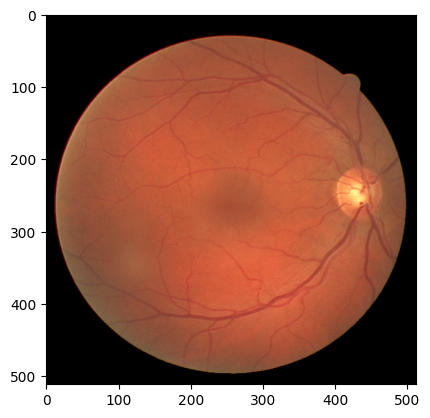

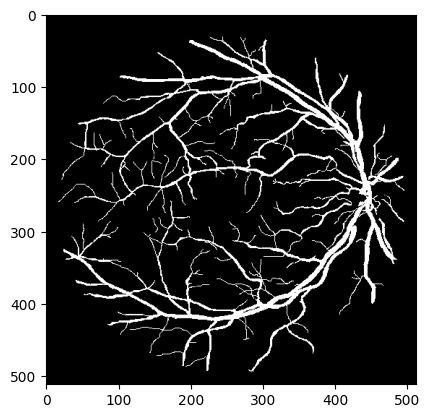

In [53]:
for batch in test_dataset:
    image, label = batch
    
    plt.imshow(image[0])
    plt.show()
    plt.imshow(label[0], cmap="gray")
    plt.show()

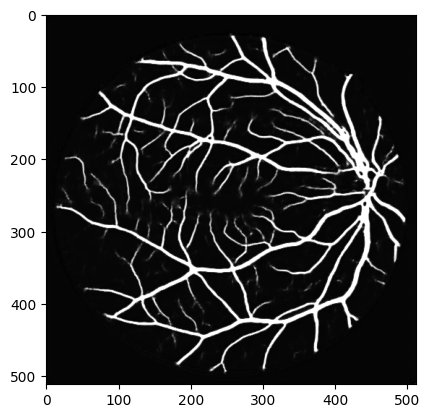